In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import PIL.ImageOps as ImageOps
import PIL.Image as Image
from tqdm import tqdm

In [2]:
class_names = ['Ocimum Tenuiflorum (Tulsi)', 'Mangifera Indica (Mango)', 'Azadirachta Indica (Neem)', 'Ficus Religiosa (Peepal Tree)', 'Murraya Koenigii (Curry)', 'Hibiscus Rosa-sinensis', 'Pongamia Pinnata (Indian Beech)', 'Jasminum (Jasmine)', 'Nerium Oleander (Oleander)', 'Plectranthus Amboinicus (Mexican Mint)', 'Alpinia Galanga (Rasna)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Citrus Limon (Lemon)', 'Nyctanthes Arbor-tristis (Parijata)', 'Amaranthus Viridis (Arive-Dantu)', 'Basella Alba (Basale)', 'Syzygium Cumini (Jamun)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)', 'Santalum Album (Sandalwood)', 'Trigonella Foenum-graecum (Fenugreek)', 'Brassica Juncea (Indian Mustard)', 'Syzygium Jambos (Rose Apple)', 'Carissa Carandas (Karanda)', 'Moringa Oleifera (Drumstick)', 'Ficus Auriculata (Roxburgh fig)', 'Mentha (Mint)', 'Piper Betle (Betel)', 'Artocarpus Heterophyllus (Jackfruit)']

class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150,150)

In [3]:
def pre_process(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    return image

In [4]:
def load_data():
    
    datasets = ['C:/Users/sanju/OneDrive/Documents/Nitheesh/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images','C:/Users/sanju/OneDrive/Documents/Nitheesh/Medicinal Leaf Dataset/Test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = pre_process(img_path) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Users/sanju/OneDrive/Documents/Nitheesh/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images


100%|██████████| 36/36 [00:00<00:00, 56.04it/s]


Loading C:/Users/sanju/OneDrive/Documents/Nitheesh/Medicinal Leaf Dataset/Test


100%|██████████| 23/23 [00:00<00:00, 59.01it/s]


In [6]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense

def InceptionV3(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='valid')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Inception blocks (repeat as needed)
    # Inception module 1
    x = InceptionModule(x, [64, 128, 32, 32, 32, 32])
    # Inception module 2
    x = InceptionModule(x, [128, 192, 96, 64, 64, 64])
    # ...

    # Global average pooling and fully connected layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = tf.keras.Model(inputs, x, name='inception_v3')
    return model

def InceptionModule(x, filters):
    # Implementation of an Inception module
    tower_1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    tower_3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    tower_3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(tower_3x3_reduce)
    tower_5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    tower_5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(tower_5x5_reduce)
    tower_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    tower_pool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(tower_pool)
    output = tf.keras.layers.concatenate([tower_1x1, tower_3x3, tower_5x5, tower_pool_proj], axis=3)
    return output

# Create the InceptionV3 model
input_shape = (150, 150, 3)  # Adjust input shape as needed
num_classes = 30  # Adjust the number of classes
model = InceptionV3(input_shape, num_classes)

# Print the model summary
model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 72, 72, 32)           9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 72, 72, 64)           18496     ['conv2d_1[0][0]']            
                                                                                       

In [8]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
12/12 [==============================] - 71s 6s/step - loss: 3.2296 - accuracy: 0.0773 - val_loss: 5.1613 - val_accuracy: 0.0000e+00
Epoch 2/20
12/12 [==============================] - 67s 6s/step - loss: 3.1697 - accuracy: 0.0616 - val_loss: 6.2036 - val_accuracy: 0.0000e+00
Epoch 3/20
12/12 [==============================] - 69s 6s/step - loss: 3.0733 - accuracy: 0.1238 - val_loss: 7.7472 - val_accuracy: 0.0000e+00
Epoch 4/20
12/12 [==============================] - 70s 6s/step - loss: 2.7795 - accuracy: 0.1259 - val_loss: 14.1834 - val_accuracy: 0.0000e+00
Epoch 5/20
12/12 [==============================] - 67s 6s/step - loss: 2.6373 - accuracy: 0.1300 - val_loss: 12.4811 - val_accuracy: 0.0000e+00
Epoch 6/20
12/12 [==============================] - 64s 5s/step - loss: 2.5603 - accuracy: 0.1327 - val_loss: 12.1272 - val_accuracy: 0.0000e+00
Epoch 7/20
12/12 [==============================] - 65s 5s/step - loss: 2.5360 - accuracy: 0.1717 - val_loss: 12.3329 - val_accuracy:

In [10]:
test_loss = model.evaluate(test_images, test_labels)

30/30 [==============================] - 6s 198ms/step - loss: 4.6775 - accuracy: 0.3898


1/1 [==============================] - 0s 22ms/step
Citrus Limon (Lemon)


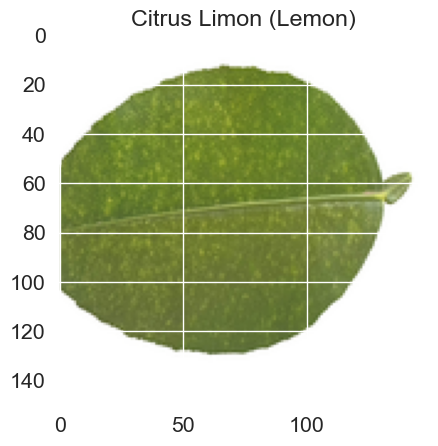

In [25]:
from PIL import Image, ImageOps
import numpy as np

data = np.ndarray(shape=(1, 150, 150, 3), dtype=np.float32)
image = Image.open('C:/Users/sanju/OneDrive/Documents/Nitheesh/Medicinal Leaf Dataset/Test/Citrus Limon (Lemon)/CL-S-002.jpg')

# Image sizing
size = (150, 150)
image = ImageOps.fit(image, size, Image.LANCZOS)  # Use a valid resampling method here

# Turn the image into a numpy array
image_array = np.asarray(image)
# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

# Load the image into the array
data[0] = normalized_image_array

# Run the inference
prediction = model.predict(data)

pred_label = np.argmax(prediction, axis=1)  # We take the highest probability
class_prediction = class_names[pred_label[0]]
print(class_prediction)
plt.title(class_prediction)
plt.imshow(image)


In [26]:
from openpyxl import load_workbook

data_file = 'C:/Users/sanju/OneDrive/Documents/Nitheesh/Ajithar Excel Sheet.xlsx'

# Load the entire workbook.
wb = load_workbook(data_file, data_only=True)

# Load one worksheet.
ws = wb['Sheet1']
all_rows = list(ws.rows)

predicted = class_prediction

# Pull information from specific cells.
for row in all_rows[1:50]:
  Plant_Names = row[0].value
  description = row[1].value


  if predicted == Plant_Names :
    print(f"\n{Plant_Names}")
    print(f"{description}")


Citrus Limon (Lemon)
Lemon: Lemons are an excellent source of Vitamin C and fiber, and therefore, it lowers the risk factors leading to heart diseases. Lemons are also known to prevent Kidney Stones as they have Citric acid that helps in preventing Kidney Stones. Lemon, with Vitamin C and citric acid helps in the absorption of iron.
